# <img src="./assets/course-icon.png" style="height:50px;display:inline"> Learning Methods of Deep Learning
---

create by Deepfinder



### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---

1. 师徒相授：有监督学习（Supervised Learning）
2. 见微知著：无监督学习（Un-supervised Learning）
3. 无师自通：自监督学习（Self-supervised Learning）
4. 以点带面：半监督学习（Semi-supervised learning）
5. 明辨是非：对比学习（Contrastive Learning）
6. **举一反三：迁移学习（Transfer Learning）**
7. 针锋相对：对抗学习（Adversarial Learning）
8. 众志成城：集成学习(Ensemble Learning) 
9. 殊途同归：联邦学习（Federated Learning）
10. 百折不挠：强化学习（Reinforcement Learning）
11. 求知若渴：主动学习（Active Learning）
12. 万法归宗：元学习（Meta-Learning）


## Tutorial 06 - 举一反三：迁移学习（Transfer Learning） 

## <img src="https://img.icons8.com/bubbles/50/000000/car.png" style="height:50px;display:inline"> 迁移学习应用
---


**Domain Adaptation** - 领域自适应：

* 核心概念：将已经在一个领域（源领域）学到的知识，迁移或适配到另外一个不同但相关的领域（目标领域）。

* 视觉（CV）示例：在图像识别任务中，我们往往在一个领域里有大量标注数据，而对真正关心的领域却没有或几乎没有标注数据。即使两者在外观上很相似，训练数据可能带有微妙的偏差，模型会利用这些偏差进行过拟合，从而对实际场景表现不佳。

**Sim2Real** - 从模拟环境迁移到真实环境

* 对于许多依赖硬件进行交互的机器学习应用来说，在现实世界中收集数据和训练模型要么**昂贵、耗时，要么太危险**。因此，建议以其他风险较小的方式收集数据。

* 常见应用包括自动驾驶和机器人技术（其中收集数据可能很慢或很危险）。

## <img src="https://img.icons8.com/nolan/64/system-task.png" style="height:50px;display:inline"> 使用预训练模型进行迁移学习
---
* 迁移学习的基本要求之一是存在在源任务上表现良好的模型。
* 建立在预训练模型之上以在任务和领域之间进行迁移的两个最常见领域是计算机视觉和 NLP。

### <img src="https://img.icons8.com/fluent/96/000000/image.png" style="height:50px;display:inline"> 使用预训练的 CNN 特征
---
* 显然，较低的卷积层捕获**低级图像特征**，例如边缘，而较高的卷积层捕获更复杂的细节，例如身体部位、面部和其他组合特征。
* **最终的全连接层**通常被认为捕获与解决相应任务（例如分类）相关的信息。
* 捕获图像如何组成以及它包含哪些边缘和形状组合的一般信息的表示**可能对其他任务有帮助**。此信息包含在 ImageNet 上训练的大型卷积神经网络中的最终卷积层或早期全连接层之一中。
* 因此，对于新任务，我们可以简单地使用在 ImageNet 上预先训练的最先进的 CNN 的现成功能，并在这些提取的功能上训练新模型。
* 在实践中，我们要么**保持预先训练的参数不变，要么以较小的学习率对其进行调整**，以确保我们不会“忘记”先前获得的知识。

### <img src="https://img.icons8.com/cotton/64/000000/olympic-torch.png" style="height:50px;display:inline"> 使用 PyTorch 进行迁移学习的示例
---
* 我们将遵循 <a href="https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html">Sasank Chilamkurthy</a> 和 <a href="https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html">Nathan Inkawhich</a> 的示例。
* 我们将训练一个分类器来区分 **蚂蚁** 和 **蜜蜂**。
* 可以从此处下载数据：<a href="https://download.pytorch.org/tutorial/hymenoptera_data.zip">下载链接</a>。
* 有两种主要的迁移学习场景：
* **微调 ConvNet**：我们不是随机初始化，而是使用预训练网络初始化网络，例如 VGG（在 ImageNet 1000 数据集上训练）。其余训练看起来与往常一样（除了通常使用较低的学习率）。
* **ConvNet 作为固定特征提取器**：在这里，我们将冻结除最终全连接层之外的所有网络的权重。最后一个全连接层被替换为具有随机权重的新层，并且只训练这一层。优点是训练速度非常快，但模型的几个部分不适应新目标。

In [24]:
import os
import numpy as np
import time
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
import matplotlib.pyplot as plt

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

batch_size = 4
data_dir = './datasets/hymenoptera_data'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                             shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


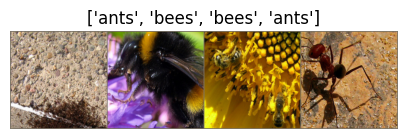

In [26]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5, 8))
    ax = fig.add_subplot(111)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.set_axis_off()

# Let’s visualize a few training images so as to understand the data augmentations.
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### 设置模型参数的 `.requires_grad` 属性
---
* 当我们进行特征提取时，以下辅助函数将模型中参数的 `.requires_grad` 属性设置为 `False`。
* 默认情况下，当我们加载预训练模型时，所有参数都有 `.requires_grad=True`，如果我们从头开始训练或进行微调，这是没问题的。
* 但是，如果我们进行特征提取并且只想计算新初始化层的梯度，那么我们希望所有其他参数都不需要梯度。

In [11]:
def set_parameter_requires_grad(model, feature_extracting=False):
    # approach 1
    if feature_extracting:
        # frozen model
        model.requires_grad_(False)
    else:
        # fine-tuning
        model.requires_grad_(True)
        
    # approach 2
    if feature_extracting:
        # frozen model
        for param in model.parameters():
            param.requires_grad = False
    else:
        # fine-tuning
        for param in model.parameters():
            param.requires_grad = True
    # note: you can also mix between frozen layers and trainable layers, but you'll need a custom 
    # function that loops over the model's layers and you specify which layers are frozen.

#### 初始化和重塑网络
---
* 回想一下，CNN 模型的最后一层（通常是 FC 层）的节点数与数据集中的输出类数相同。
* 由于以下所有模型都已在 ImageNet 上进行了预训练，因此它们都具有大小为 1000 的输出层，每个类一个节点。
* 这里的目标是**重塑最后一层，使其具有与之前相同数量的输入**，并且具有**与数据集中的类数相同的输出数量**。

* 在*特征提取*时，我们只想更新最后一层的参数，换句话说，我们只想更新我们正在重塑的层的参数。
* 因此，我们不需要计算我们不改变的参数的梯度，所以为了提高效率，我们将 `.requires_grad` 属性设置为 `False`。
* 这很重要，因为默认情况下，此属性设置为 `True`。然后，当我们初始化新层时，默认情况下新参数具有 `.requires_grad=True`，因此只有新层的参数会被更新。
* 当我们进行微调时，我们可以将所有 `.required_grad` 设置为默认值 `True`。

### <img src="https://img.icons8.com/nolan/64/download-from-cloud.png" style="height:50px;display:inline"> Torchvision 预训练模型
---
* `torchvision.models` 子包包含用于解决不同任务的模型定义，包括：图像分类、像素级语义分割、对象检测、实例分割、人物关键点检测、视频分类和光流。
* 您可以在此处查看所有可用内容 - <a href="https://pytorch.org/vision/stable/models.html">模型和预训练权重</a>。
* 在代码中，您可以使用 <a href="https://pytorch.org/vision/stable/models.html#listing-and-retrieving-available-models">`torchvision.models.list_models`</a> 查看所有可用模型的列表。
* 示例：

In [27]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0  # image size, e.g. (3, 224, 224)
    # new method from torchvision >= 0.13
    weigths = 'DEFAULT' if use_pretrained else None 
    # to use other checkpoints than the default ones, check the model's available chekpoints here:
    # https://pytorch.org/vision/stable/models.html
    if model_name == "resnet":
        """ Resnet18
        """
        # new method from torchvision >= 0.13
        model_ft = models.resnet18(weights=weights)
        # old method for toechvision < 0.13
        # model_ft = models.resnet18(pretrained=use_pretrained)
        
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes) # replace the last FC layer
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        # new method from torchvision >= 0.13
        model_ft = models.alexnet(weights=models)
        # old method for toechvision < 0.13
        # model_ft = models.alexnet(pretrained=use_pretrained)
        
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG16
        """
        # new method from torchvision >= 0.13
        model_ft = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        # old method for toechvision < 0.13
        # model_ft = models.vgg16(pretrained=use_pretrained)
        
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        # new method from torchvision >= 0.13
        model_ft = models.squeezenet1_0(weights=weights)
        # old method for torchvision < 0.13
        # model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        # new method from torchvision >= 0.13
        model_ft = models.densenet121(weights=weights)
        # old method for torchvision < 0.13
        # model_ft = models.densenet121(pretrained=use_pretrained)
        
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        raise NotImplementedError

    return model_ft, input_size

In [28]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
model_name = "vgg"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 5

# Flag for feature extracting. When False, we fine-tune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [29]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  fine-tuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []  # override the initial list definition above
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [31]:
import copy
"""
Training function
"""
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [32]:
# Setup the loss fn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/4
----------
train Loss: 0.3457 Acc: 0.8770
val Loss: 0.1964 Acc: 0.9346

Epoch 1/4
----------
train Loss: 0.2492 Acc: 0.9139
val Loss: 0.1017 Acc: 0.9739

Epoch 2/4
----------
train Loss: 0.2920 Acc: 0.9303
val Loss: 0.1045 Acc: 0.9673

Epoch 3/4
----------
train Loss: 0.1478 Acc: 0.9385
val Loss: 0.2151 Acc: 0.9216

Epoch 4/4
----------
train Loss: 0.2607 Acc: 0.9180
val Loss: 0.1252 Acc: 0.9477

Training complete in 0m 9s
Best val Acc: 0.973856


### <img src="https://img.icons8.com/cute-clipart/64/000000/language.png" style="height:50px;display:inline"> 自然语言处理的预训练
---
* NLP 面临的最大挑战之一是标记训练数据的短缺。
* 由于 NLP 是一个多元化的领域，具有许多不同的任务，因此大多数特定于任务的数据集仅包含几千或几十万个人工标记的训练示例。
* 正如 Google 和 OpenAI 等大公司所展示的那样，**基于现代深度学习的 NLP 模型从大量数据中获益，在对数百万或数十亿个带注释的训练示例进行训练时会得到改进**。
* 然后可以在小数据 NLP 任务（如问答和情绪分析）上对大量**网络上未注释文本**上的大型预训练模型进行微调，与从头开始对这些数据集进行训练相比，准确性有了显着提高。
* **Transformers 的双向编码器表示 (BERT)，Google** - Google 开发的用于自然语言处理 (NLP) 预训练的基于 Transformer 的机器学习技术。其思想是屏蔽某些单词，然后尝试预测它们。原始的英语 BERT 模型带有两种预训练的通用类型：
* (1) $BERT_{BASE}$ 模型，12 层、768 个隐藏、12 个头、110M 参数神经网络架构。
* (2) $BERT_{LARGE}$ 模型，24 层、1024 个隐藏、16 个头、340M 参数神经网络架构。
* 两者都是在包含 800M 单词的 BooksCorpus 数据集和包含 2,500M 单词的英文维基百科版本上进行训练的。
* BERT 使用简单的技术来屏蔽输入中的某些单词，然后双向调节每个单词以预测被屏蔽的单词，同时通过对可以从任何文本语料库生成的非常简单的任务进行预训练来学习建模句子之间的关系：给定两个句子 A 和 B，B 是语料库中 A 之后的实际下一个句子，还是只是一个随机句子？

<center><img src="./assets/bert_1.png" style="height:50px"></center>

<center><img src="./assets/bert_ill_1.png" style="height:350px"></center>

* <a href="https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html">Image Source 1</a>, <a href="http://jalammar.github.io/illustrated-bert/">Image Source 2</a>

<center><img src="./assets/bert_2.png" style="height:100px"></center>
<center><img src="./assets/bert_ill_2.png" style="height:350px"></center>

* <a href="https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html">Image Source 1</a>, <a href="http://jalammar.github.io/illustrated-bert/">Image Source 2</a>

#### PyTorch 中用于 NLP 的预训练模型
---
* <a href="https://huggingface.co/">HuggingFace</a> 是一家致力于发布所有可用预训练模型的公司，它也适用于 PyTorch - <a href="https://github.com/huggingface/transformers">HuggingFace Transformers</a>
* <a href="https://pytorch.org/hub/huggingface_pytorch-transformers/">使用 PyTorch 的示例</a>
* <a href="https://huggingface.co/docs/transformers/training">教程：使用 PyTorch 和 HuggingFace 对用于 NLP 任务的 Transformers 进行微调</a>。

#### <img src="./assets/torch_icon.jfif" style="height:50px;display:inline"> TorchTune 库 - 使用 LLM 进行微调和实验
---
* <a href="https://github.com/pytorch/torchtune">TorchTune</a> 是一个原生 Pytorch 库，可轻松编写、微调和使用 LLM 进行实验。
* 流行 LLM 的原生 PyTorch 实现，支持各种格式的检查点，包括 HuggingFace 格式的检查点。
* <a href="https://github.com/pytorch/torchtune">GitHub 上的 TorchTune</a>

<center><img src="./assets/torchtune_gh.PNG" style="height:200px"></center>

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons made by <a href="https://www.flaticon.com/authors/becris" title="Becris">Becris</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a>
* Icons from <a href="https://icons8.com/">Icons8.com</a> - https://icons8.com
* Datasets from <a href="https://www.kaggle.com/">Kaggle</a> - https://www.kaggle.com/
* <a href="https://machinelearningmastery.com/why-initialize-a-neural-network-with-random-weights/">Jason Brownlee - Why Initialize a Neural Network with Random Weights?</a>
* <a href="https://openai.com/blog/deep-double-descent/">OpenAI - Deep Double Descent</a>
* <a href="https://taldatech.github.io">Tal Daniel</a>